In [1]:
import pandas as pd
import numpy as np

In [2]:
from tensorflow import keras

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from sklearn.model_selection import KFold

In [5]:
from IPython.display import clear_output

In [6]:
from matplotlib import pyplot as plt

In [7]:
from itertools import product

In [53]:
from math import prod

In [57]:
from GPyOpt.methods import BayesianOptimization

# Data preparation

Data can be found [here](http://mlr.cs.umass.edu/ml/machine-learning-databases/census-income/).

In [8]:
data = pd.read_csv(
#     "/cluster/scratch/bramva/deep-learning-course/data/census-income/census-income.data",
    "data/census-income.data",
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ],
)

In [9]:
categoricals = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "income",
]

In [10]:
data.describe(include="all")

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [11]:
data.iloc[0, :]

age                           39
workclass              State-gov
fnlwgt                     77516
education              Bachelors
education-num                 13
marital-status     Never-married
occupation          Adm-clerical
relationship       Not-in-family
race                       White
sex                         Male
capital-gain                2174
capital-loss                   0
hours-per-week                40
native-country     United-States
income                     <=50K
Name: 0, dtype: object

In [12]:
for categorical in categoricals:
    data[categorical] = LabelEncoder().fit_transform(data[categorical])
    values = data[categorical].unique()
    np.random.shuffle(values)
    data[categorical] = values[data[categorical]]

In [13]:
means = data.mean()

In [14]:
data -= means

In [15]:
stds = data.std()

In [16]:
data /= stds

In [17]:
dataset = data.values

In [18]:
ordering = np.arange(dataset.shape[0])
np.random.shuffle(ordering)
dataset = dataset[ordering]

In [19]:
cutoff = round(dataset.shape[0] * .1)

In [20]:
train, labels = dataset[:, 1:], dataset[:, 0]

# Utilities

In [21]:
class PlotLosses(keras.callbacks.Callback):
    def __init__(
        self,
        metrics=None,
        validation=True,
    ):
        self.metrics = ["loss"]
        if metrics:
            self.metrics += metrics
        if validation:
            for i in reversed(range(len(self.metrics))):
                self.metrics.insert(i + 1, "val_" + self.metrics[i])
        self.hist_metrics = [list() for metric in self.metrics]
        
    def on_train_begin(self, logs={}):
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        for metric, hist_metric in zip(self.metrics, self.hist_metrics):
            hist_metric.append(logs.get(metric))

        clear_output(wait=True)
        
        self.fig = plt.figure(figsize=(15, 7))
        for metric, hist_metric in zip(self.metrics, self.hist_metrics):
            plt.plot(range(len(self.hist_metrics[0])), hist_metric, label=metric)
        plt.legend()
        plt.show()

    def __len__(self):
        return len(self.hist_metrics[0])

# Model

In [22]:
def build_model(
    before_trainable_layers=[],
    random_layers=[],
    after_trainable_layers=[],
    regularization_factor=.1,
):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(train.shape[1])))
    
    for i, layer_size in enumerate(before_trainable_layers):
        model.add(keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l1(
                (0 if i == 0 else .01 / 50 * before_trainable_layers[i - 1]) * regularization_factor,
            ),
        ))
        
    for random_layer_size in random_layers:
        model.add(keras.layers.Dense(
            random_layer_size,
            activation="tanh",
            trainable=False,
        ))
    
    for i, layer_size in enumerate(after_trainable_layers):
        model.add(keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l1(
                (
                    .01 / 50 * random_layers[-1] if i == 0 else .01 / 5 * after_trainable_layers[i - 1]
                ) * regularization_factor,
            ),
        ))
        
    model.add(keras.layers.Dense(1))
    return model

In [23]:
folds = 10

In [62]:
sizes = [10, 100]
max_depth = 2

before_options = [[], [100]]
random_options = [[size] * i for size in sizes for i in range(max_depth + 1)]
after_options = [[], [10]]

In [63]:
model_configurations = np.array(list(product(before_options, random_options, after_options)))
model_configurations = model_configurations.reshape(
    len(before_options), 
    len(sizes),
    max_depth + 1,
    len(after_options),
    len((before_options, random_options, after_options)),
)
model_configurations.shape, prod(model_configurations.shape), prod(model_configurations.shape) * folds

((2, 2, 3, 2, 3), 72, 720)

In [65]:
model = build_model([], [10], [100])
model.compile(optimizer="adam", loss="mean_squared_error")

In [66]:
epsilon = 1e-12
def log_space(x): return np.log(x + epsilon)
def un_log_space(x): return np.exp(x) - epsilon

In [68]:
domain = [
    {
        "name": "l1_factor",
        "type": "continuous",
        "domain": (log_space(0), log_space(1e2)),
    }
]

In [72]:
def test(hyperparameters):
    l1_factor = hyperparameters[0, 0]
    
    model = build_model([], [middle_size], [100], un_log_space(l1_factor))
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    train_ids, test_ids = next(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0])))
    half_validate = round(len(test_ids) / 2)
    
    model.fit(
        train[train_ids], labels[train_ids],
        32,
        epochs=100,
        shuffle=True,
        validation_data=(
            train[test_ids][:half_validate], labels[test_ids][:half_validate],
        ),
        callbacks=[
            keras.callbacks.EarlyStopping(
                patience=5,
                restore_best_weights=True,
            ),
            PlotLosses(),
        ],
    )
    
    score = model.evaluate(
        train[test_ids][half_validate:], labels[test_ids][half_validate:],
        verbose=0,
    )
    
    return score

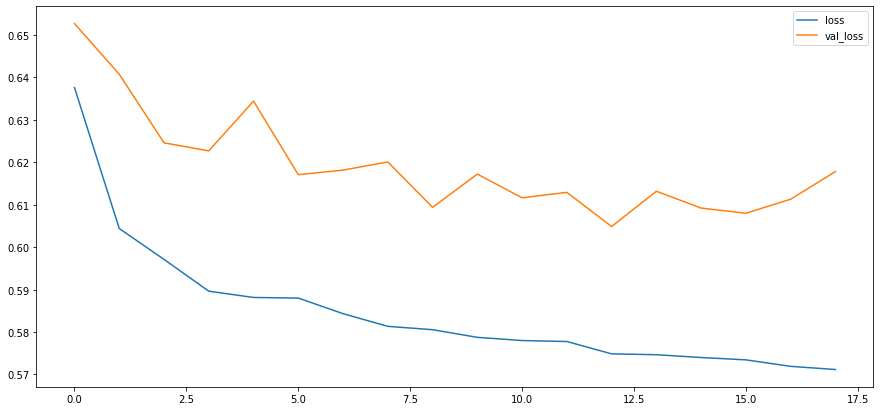

29304/29304 [==============================] - 2s 59us/sample - loss: 0.5712 - val_loss: 0.6178


In [73]:
results = list()
for middle_size in [10, 100, 1000]:
    bo = BayesianOptimization(
        f=test,
        domain=domain,
    )
    
    bo.run_optimization(50)
    results.append((middle_size, bo.x_opt))

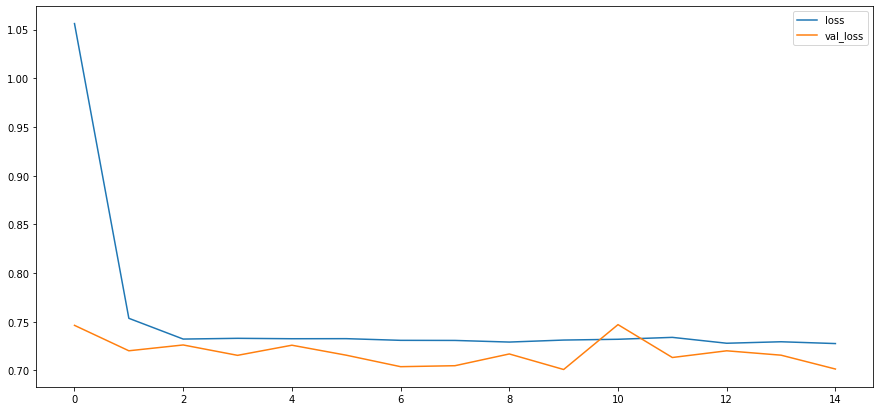

29304/29304 [==============================] - 5s 185us/sample - loss: 0.7276 - val_loss: 0.7015


In [ ]:
middle_size = 10000
bo = BayesianOptimization(
    f=test,
    domain=domain,
)

bo.run_optimization(50)
results.append((middle_size, bo.x_opt))

In [ ]:
list(map(lambda t: (t[0], un_log_space(t[1])), results))

In [25]:
for model_type in models:
    for model in model_type:
        model.compile(
            optimizer="adam",
            loss="mean_squared_error",
        )

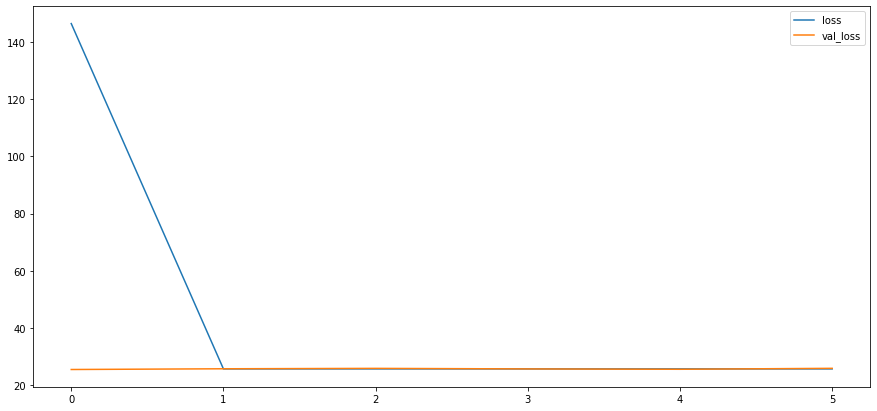

29305/29305 [==============================] - 7s 225us/sample - loss: 25.6869 - val_loss: 25.8871


In [26]:
testsets = list()
for i, model in enumerate(models):
    model_type_testsets = list()
    for j, (train_ids, test_ids) in enumerate(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0]))):
        print(i)
        model_type_testsets.append(test_ids)
        half_validate = round(len(test_ids) / 2)
        
        models[i][j].fit(
            train[train_ids], labels[train_ids],
            32,
            epochs=100,
            shuffle=True,
            validation_data=(
                train[test_ids][:half_validate], labels[test_ids][:half_validate],
            ),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=5,
                    restore_best_weights=True,
                ),
                PlotLosses(),
            ],
        )
        
    testsets.append(model_type_testsets)

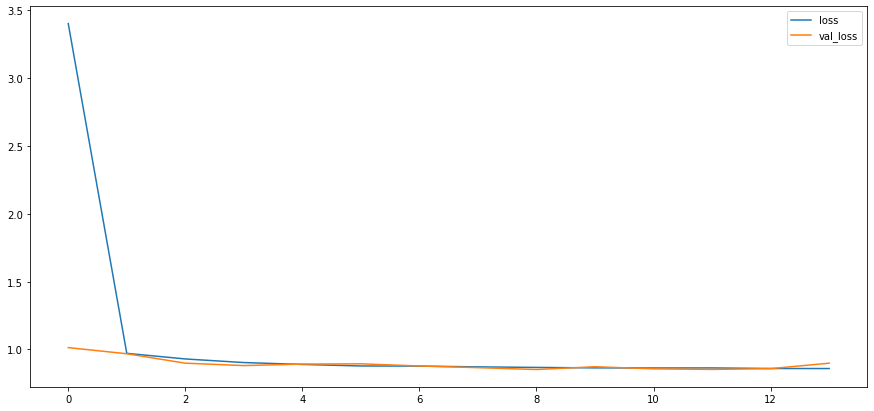

29304/29304 [==============================] - 4s 143us/sample - loss: 0.8590 - val_loss: 0.8986


In [52]:
m = build_model([100], [1000] * 3, [100, 10], regularization_factor=.1)
m.compile(
    optimizer="adam",
    loss="mean_squared_error",
)
train_ids, test_ids = next(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0])))
half_validate = round(len(test_ids) / 2)

m.fit(
    train[train_ids], labels[train_ids],
    32,
    epochs=100,
    shuffle=True,
    validation_data=(
        train[test_ids][:half_validate], labels[test_ids][:half_validate],
    ),
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True,
        ),
        PlotLosses(),
    ],
)

In [53]:
m.summary()

Model: "sequential_556"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3019 (Dense)           (None, 100)               1500      
_________________________________________________________________
dense_3020 (Dense)           (None, 1000)              101000    
_________________________________________________________________
dense_3021 (Dense)           (None, 1000)              1001000   
_________________________________________________________________
dense_3022 (Dense)           (None, 1000)              1001000   
_________________________________________________________________
dense_3023 (Dense)           (None, 100)               100100    
_________________________________________________________________
dense_3024 (Dense)           (None, 10)                1010      
_________________________________________________________________
dense_3025 (Dense)           (None, 1)              

In [57]:
m.evaluate(
    train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
    verbose=0,
)

0.8203661965035894

In [34]:
results = [
    [
        model.evaluate(
            train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
            verbose=0,
        ) for model, test_ids in zip(model_type, testset_list)
    ] for model_type, testset_list in zip(models, testsets)
]

In [35]:
for model_type, result_list in zip(models, results):
    model_type[0].summary()
    print("\n", "score:", np.mean(result_list), "\t", np.std(result_list), "\n\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________

 score: 0.8401855314549076 	 0.030949582261313748 


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                150       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 1)           

dense_2800 (Dense)           (None, 100)               1500      
_________________________________________________________________
dense_2801 (Dense)           (None, 1000)              101000    
_________________________________________________________________
dense_2802 (Dense)           (None, 1000)              1001000   
_________________________________________________________________
dense_2803 (Dense)           (None, 10)                10010     
_________________________________________________________________
dense_2804 (Dense)           (None, 1)                 11        
Total params: 1,113,521
Trainable params: 1,012,521
Non-trainable params: 101,000
_________________________________________________________________

 score: 25.473135230795194 	 0.041470647312468085 


Model: "sequential_530"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2850 (Dense)           (None, 100)        

In [36]:
as_array = np.array(results)

In [37]:
np.savetxt("results.np", as_array)